Finding best hyperparameters...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


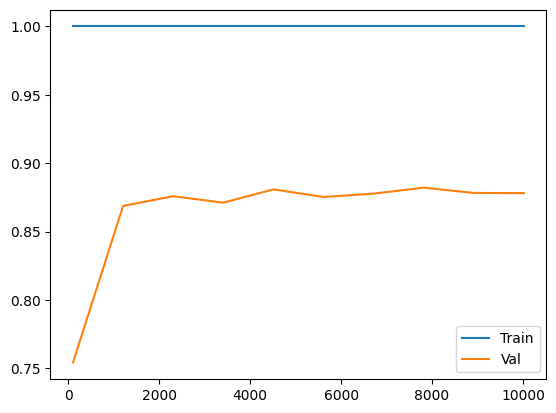

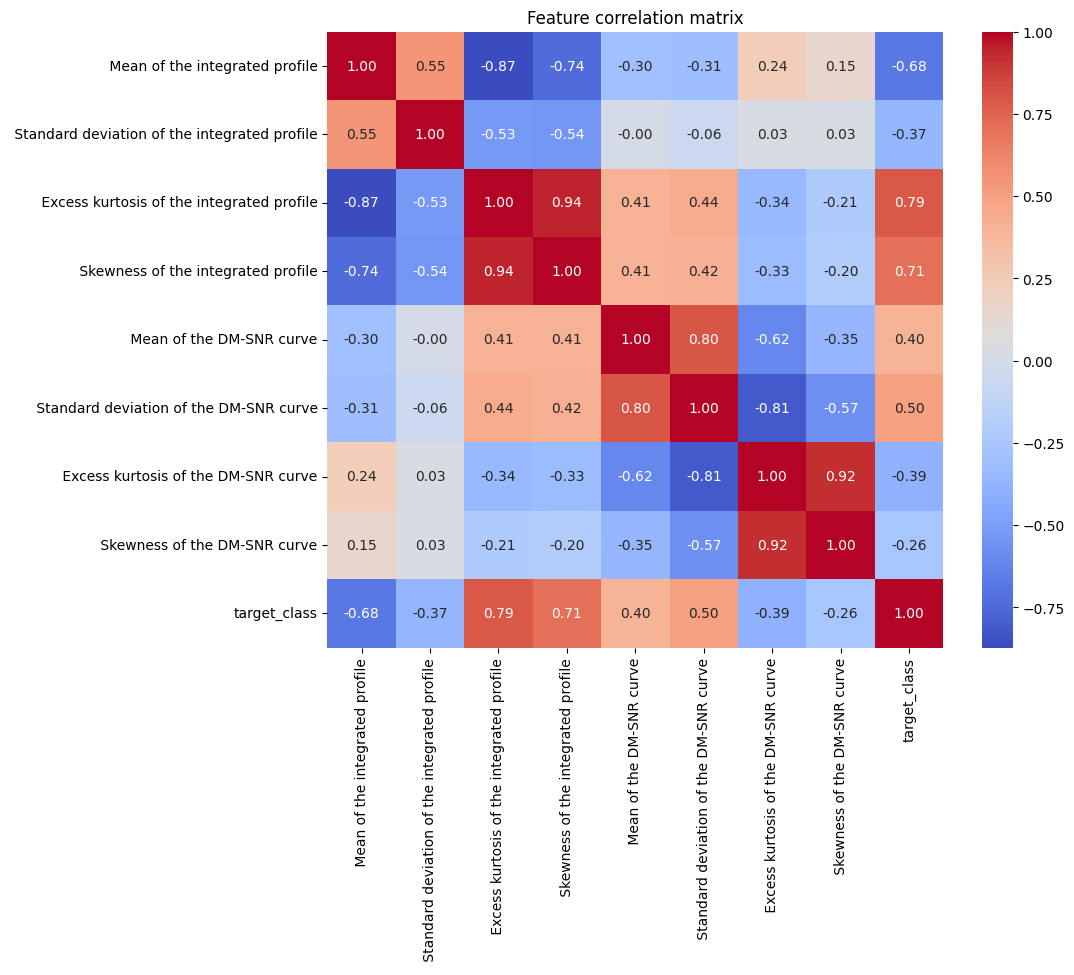

Hyperparameter tuning time: 66.63124227523804
Optimal hyperparameters: {'lgbmclassifier__reg_lambda': np.float64(0.2), 'lgbmclassifier__reg_alpha': np.float64(0.0), 'lgbmclassifier__max_depth': np.int64(9), 'lgbmclassifier__learning_rate': np.float64(0.35000000000000003)}
Cross validation score: 0.8722784832400668
Final model training time: 0.215 s
Total training time: 66.8469467163086


In [11]:
from lightgbm import LGBMClassifier
import time
import pandas as pd
from sklearn.pipeline import make_pipeline
import joblib
from hyperparameter_tuning import hyper_parameter_tuning
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import seaborn as sns

def hyper_parameter_tuning(model,X_train,y_train,n_iter,learning_rate_min,learning_rate_max,learning_rate_step,max_depth_min,max_depth_max,max_depth_step,
                           reg_lambda_min,reg_lambda_max,reg_lambda_step,reg_alpha_min,reg_alpha_max,reg_alpha_step,n_neighbors_min,n_neighbors_max,n_neighbors_step):
    parameter_distributions = {
    "lgbmclassifier__max_depth" : np.arange(max_depth_min,max_depth_max,max_depth_step),
    "lgbmclassifier__learning_rate" : np.arange(learning_rate_min,learning_rate_max,learning_rate_step),
    "lgbmclassifier__reg_lambda" : np.arange(reg_lambda_min,reg_lambda_max,reg_lambda_step),
    "lgbmclassifier__reg_alpha" : np.arange(reg_alpha_min,reg_alpha_max,reg_alpha_step)
    #"knnimputer__n_neighbors" : np.arange(n_neighbors_min,n_neighbors_max,n_neighbors_step)
    }
    print("Finding best hyperparameters...")
    grid = RandomizedSearchCV(estimator=model,param_distributions=parameter_distributions,n_iter=n_iter,cv=5,scoring='f1',n_jobs=-1,verbose=1)
    
    grid.fit(X_train,y_train)
    
    return grid.best_params_, grid.best_score_

# Hyperparameter tuning ranges
learning_rate_min,learning_rate_max,learning_rate_step = 0.05, 0.45, 0.1
max_depth_min, max_depth_max, max_depth_step = 5, 11, 2
n_estimators = 100
reg_lambda_min, reg_lambda_max, reg_lambda_step = 0, 0.8, 0.2  # Like L2 (Ridge) regularization on leaf nodes
reg_alpha_min, reg_alpha_max, reg_alpha_step = 0, 0.8, 0.2   # Like L1 (Lasso) regularization on leaf nodes
n_neighbors_min, n_neighbors_max, n_neighbors_step = 3, 9, 2

# Random search iterations in hyperparameter tuning
n_iter = 100

# Read data
df_train = pd.read_csv("../Data/pulsar_data_train.csv", comment="#")

X_train = df_train.drop('target_class', axis=1)
y_train = df_train['target_class'].copy()

# Split data: 60% Training, 20% Validation, 20% Test
# Validation set used only for early stopping
X_tr, X_test, y_tr, y_test = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=54
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=54
)

# Save data split to csv files
X_test.to_csv("../Data/X_test.csv", index=False)
y_test.to_csv("../Data/y_test.csv", index=False)

# Impute validation data for early stopping for the final model.
imputer = KNNImputer(n_neighbors=5)
X_val_imp = imputer.fit_transform(X_val)

#print(X_train.head())

pos = (y_tr==1).sum()
neg = (y_tr==0).sum()
spw = neg/pos

LGBM_model = make_pipeline( 
                            #KNNImputer(), 
                            LGBMClassifier(n_estimators=n_estimators, random_state=54,
                                          n_jobs=-1, scale_pos_weight=spw, verbose=-1))

start_time_hpt = time.time()
best_params, best_score = hyper_parameter_tuning(LGBM_model,X_tr,y_tr,n_iter,learning_rate_min, learning_rate_max, learning_rate_step, 
                                                 max_depth_min, max_depth_max, max_depth_step,
                                                 reg_lambda_min, reg_lambda_max, reg_lambda_step, reg_alpha_min, reg_alpha_max, reg_alpha_step, n_neighbors_min, 
                                                 n_neighbors_max, n_neighbors_step)
end_time_hpt = time.time()

# Train model with optimal hyperparameters
final_LGBM_model = make_pipeline(
                                    #KNNImputer(n_neighbors=best_params['knnimputer__n_neighbors']),
                                    LGBMClassifier(n_estimators=n_estimators, random_state=54,
                                    n_jobs=-1, scale_pos_weight=spw, learning_rate=best_params['lgbmclassifier__learning_rate'],
                                    max_depth=best_params['lgbmclassifier__max_depth'],
                                    reg_alpha=best_params['lgbmclassifier__reg_alpha'],
                                    reg_lambda=best_params['lgbmclassifier__reg_lambda'],verbose=-1))

start_time_train = time.time() 
# Fit final model to training data
final_LGBM_model.fit(X_tr, y_tr)  
end_time_train = time.time()
# Save model as .pkl file  
joblib.dump(final_LGBM_model, "model.pkl")

# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(final_LGBM_model, X_train, y_train, cv=5, scoring="f1", train_sizes=np.linspace(0.01, 1.0, 10))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Val')
plt.legend(); plt.show()

# Plot correlation matrix
corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature correlation matrix")
plt.show()

print(f"Hyperparameter tuning time: {end_time_hpt-start_time_hpt}\nOptimal hyperparameters: {best_params}\nCross validation score: {best_score}")
print(f"Final model training time: {round(end_time_train-start_time_train,3)} s")
print(f"Total training time: {end_time_train-start_time_hpt}")

Probability that an example positive sample is positive: 0.9999996961747365
Probability that a negative example sample is positive: 2.735651563502695e-05
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2275
         1.0       0.88      0.84      0.86       231

    accuracy                           0.97      2506
   macro avg       0.93      0.92      0.92      2506
weighted avg       0.97      0.97      0.97      2506



Text(0.5, 1.0, 'Confusion matrix')

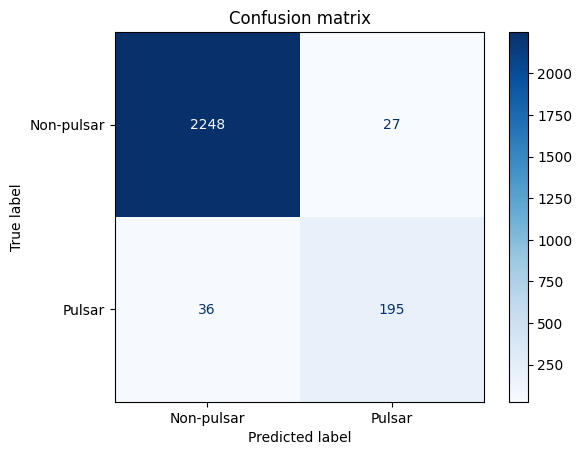

In [8]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Read data
X_test = pd.read_csv("../Data/X_test.csv", comment="#", skip_blank_lines=True)
y_test = pd.read_csv("../Data/y_test.csv", comment="#", skip_blank_lines=True)

feature_names = [
    ' Mean of the integrated profile',
    ' Standard deviation of the integrated profile',
    ' Excess kurtosis of the integrated profile',
    ' Skewness of the integrated profile',
    ' Mean of the DM-SNR curve',
    ' Standard deviation of the DM-SNR curve',
    ' Excess kurtosis of the DM-SNR curve',
    ' Skewness of the DM-SNR curve'
]

false_sample_values = [121.15625,48.37297113,0.375484665,-0.013165488999999999,3.168896321,18.399366600000004,7.449874148999999,65.15929771]
true_sample_values = [41.7734375,30.20948083,3.552223686,20.28308868,12.72993311,43.22134994,3.791869842,14.13000943]
X_sample_false = pd.DataFrame([false_sample_values], columns=feature_names)
X_sample_true = pd.DataFrame([true_sample_values], columns=feature_names)

model = joblib.load("model.pkl")
print(f"Probability that an example positive sample is positive: {model.predict_proba(X_sample_true)[0][1]}\nProbability that a negative example sample is positive: {model.predict_proba(X_sample_false)[0][1]}")

y_pred = model.predict(X_test)
cla_rep = classification_report(y_test,y_pred)
print(cla_rep)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-pulsar", "Pulsar"])
disp.plot(cmap="Blues")
plt.title("Confusion matrix")